<a href="https://colab.research.google.com/github/elenasofia98/PracticalNLP-2023-2024/blob/main/HoL06_1_XAI_Kermit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Explainability

'Black box models,' as they are often called, underlie most artificial intelligence systems.

Expecially Deep NN models are powerful but hard to understand.

- What aspects of input does the model pay attention to?
- What knowledge does the model learn to perform a task?
- How does is the input/knowledge used to generate output?
- How does the information flow through the model?

# Explainability by design

In [3]:
!git clone https://github.com/ART-Group-it/KERMIT.git
!pip install ./KERMIT/kerMIT

Cloning into 'KERMIT'...
remote: Enumerating objects: 653, done.
remote: Counting objects: 100% (234/234), done.
remote: Compressing objects: 100% (192/192), done.
remote: Total 653 (delta 163), reused 62 (delta 41), pack-reused 419
Receiving objects: 100% (653/653), 14.66 MiB | 24.09 MiB/s, done.
Resolving deltas: 100% (335/335), done.
Processing ./KERMIT/kerMIT
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.7/55.7 kB 1.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for kerMIT: filename=kerMIT-2.0-py3-none-any.whl size=203665 sha256=62cb9aae6d8cfbf5f2bfcaf1d6fdf9623f6757f34ec5a70bd8e21214281ee035
  Stored in directory: /tmp/pip-ephem-wheel-cache-mwc593a1/wheels/b5/83/6e/92611dbf1d7b0ec1799f68368b47833243d7bfc31560b5d4cb
  Created wheel for colormap: filename=colormap-1.0.6-py3-none-any.whl size=15824 sha256=7692d4ce1bdc269e78e86500a84f9d8287d84e99dd0b8e7b99f06760fc488319
  

In [4]:
!pip install stanza

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 933.2/933.2 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 397.5/397.5 kB 30.9 MB/s eta 0:00:00


In [5]:
import stanza
nlp = stanza.Pipeline('en', processors='tokenize,pos,constituency')

INFO:stanza:Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES


INFO:stanza:Loading these models for language: en (English):
| Processor    | Package             |
--------------------------------------
| tokenize     | combined            |
| mwt          | combined            |
| pos          | combined_charlm     |
| constituency | ptb3-revised_charlm |

INFO:stanza:Using device: cpu
INFO:stanza:Loading: tokenize
INFO:stanza:Loading: mwt
INFO:stanza:Loading: pos
INFO:stanza:Loading: constituency
INFO:stanza:Done loading processors!


## Create dataset

In [83]:
TREE_DIM = 64
LAMBDA = 0.7

In [84]:
import ast, os, pickle
from kerMIT.dtk import DT
from kerMIT.tree import Tree
from kerMIT.operation import fast_shuffled_convolution

#takes a tree in parenthetical form and returns a vector of size 4000
def createDT(parenthetical_tree):
    tree = Tree(string=parenthetical_tree)
    dtCalculator = DT(dimension=TREE_DIM, LAMBDA=LAMBDA, operation=fast_shuffled_convolution)
    distributedTree1 = dtCalculator.dt(tree=tree)
    return distributedTree1



#takes sentences and parse freetext in parenthetical tree
def parse(text):
    text = (text.encode('ascii', 'ignore')).decode("utf-8")

    try:
        try:
            doc = nlp(text)
        except Exception:
            return "(S)"

        senteces = doc.sentences
        #check if there are more than one sentence
        if len(senteces) <= 1:
            root = str(senteces[0].constituency)
        else:
            s1 = str(senteces[0].constituency)
            root = "(S" + s1
            for sentence in senteces[1:]:
                s2 = str(sentence.constituency)
                root = root + s2
            root = root + ")"
        return root
    except Exception:
        return "(S)"

In [85]:
import time, pickle, ast, os
from tqdm import tqdm
import pandas as pd
import numpy as np

In [86]:
!pip install datasets
from datasets import load_dataset

In [87]:
dataset = load_dataset("glue", "mrpc",  split={"train":'train[:40%]','validation':'validation[:50%]'})
dataset

DatasetDict({
    train: Dataset({
        features: ['sentence1', 'sentence2', 'label', 'idx'],
        num_rows: 1467
    })
    validation: Dataset({
        features: ['sentence1', 'sentence2', 'label', 'idx'],
        num_rows: 204
    })
})

In [88]:
def parse_dataset(dataset):
    dtrees = {}
    ptrees = {}

    # In case the parsing is not working
    tree = "(S)"
    treeException = createDT(tree)
    errors = 0

    for split in ['train', 'validation']:
        print(split)
        dtrees[split] = {}
        ptrees[split] = {}

        for example in tqdm(dataset[split]):
            for i in range(1,3):
                #try:
                tree = parse(example[f'sentence{i}'])
                dt = createDT(tree)
                #except Exception:
                #    tree, dt = "(S)", treeException
                #    errors +=1

                if f'sentence{i}' not in dtrees[split]:
                    dtrees[split][f'sentence{i}'] = []
                dtrees[split][f'sentence{i}'].append(dt)

                if f'sentence{i}' not in ptrees[split]:
                    ptrees[split][f'sentence{i}'] = []
                ptrees[split][f'sentence{i}'].append(tree)

        for i in range(1,3):
            with open(f'dts-{split}-sentence{i}', 'wb') as f:
                pickle.dump(dtrees[split][f'sentence{i}'], f)
            with open(f'pts-{split}-sentence{i}', 'wb') as f:
                pickle.dump(ptrees[split][f'sentence{i}'], f)


change_dim = True
if not os.path.exists('pts-train-sentence1'):
    parse_dataset(dataset)

elif not os.path.exists('dts-train-sentence1') or change_dim:
    ptrees = {}
    dtrees = {}
    for split in ['train', 'validation']:
        ptrees[split] = dict()
        dtrees[split] = dict()

        for i in range(1,3):
            with open(f'pts-{split}-sentence{i}', 'rb') as f:
                ptrees[split][f'sentence{i}'] = pickle.load(f)

        for i in range(1,3):
            for tree in tqdm(ptrees[split][f'sentence{i}']):
                #try:
                dt = createDT(tree)
                #except Exception:
                #    tree, dt = "(S)", treeException
                #    errors +=1

                if f'sentence{i}' not in dtrees[split]:
                    dtrees[split][f'sentence{i}'] = []
                dtrees[split][f'sentence{i}'].append(dt)


        for i in range(1,3):
            with open(f'dts-{split}-sentence{i}', 'wb') as f:
                pickle.dump(dtrees[split][f'sentence{i}'], f)


dtrees = {}
ptrees = {}

for split in ['train', 'validation']:

    dtrees[split] = dict()
    ptrees[split] = dict()

    for i in range(1,3):
        with open(f'dts-{split}-sentence{i}', 'rb') as f:
            dtrees[split][f'sentence{i}'] = pickle.load(f)
        with open(f'pts-{split}-sentence{i}', 'rb') as f:
            ptrees[split][f'sentence{i}'] =  pickle.load(f)

100%|██████████| 204/204 [00:00<00:00, 251.20it/s]


In [89]:
import torch
from torch import nn

In [90]:
from torch.utils.data import TensorDataset, random_split

def train_valid_dataset(sentences1, sentences2, labels):
    sentences1 = torch.stack([torch.from_numpy(x).float() for x in sentences1], 0)
    sentences2 = torch.stack([torch.from_numpy(x).float() for x in sentences2], 0)
    labels = nn.functional.one_hot(torch.tensor(labels)).float()

    print("sentences1.shape:", sentences1.shape,
          "sentences2.shape:", sentences2.shape,
          "labels.shape:", labels.shape)

    sentences = torch.cat((sentences1, sentences2), 1)
    print("sentences.shape: ", sentences.shape)

    # Combine the training inputs into a TensorDataset.
    train_dataset = TensorDataset(sentences, labels)

    # Create a 90-10 train-validation split.

    # Calculate the number of samples to include in each set.
    train_size = int(0.9 * len(train_dataset))
    val_size = len(train_dataset) - train_size

    # Divide the dataset by randomly selecting samples.
    train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

    print('{:>5,} training samples'.format(train_size))
    print('{:>5,} validation samples'.format(val_size))

    return train_dataset, val_dataset

def test_dataset(sentences1, sentences2, labels):
    sentences1 = torch.stack([torch.from_numpy(x).float() for x in sentences1], 0)
    sentences2 = torch.stack([torch.from_numpy(x).float() for x in sentences2], 0)
    labels = nn.functional.one_hot(torch.tensor(labels)).float()

    print("sentences1.shape:", sentences1.shape,
          "sentences2.shape:", sentences2.shape,
          "labels.shape:", labels.shape)

    sentences = torch.cat((sentences1, sentences2), 1)
    print("sentences.shape: ", sentences.shape)

    # Combine the training inputs into a TensorDataset.
    test_dataset = TensorDataset(sentences, labels)
    return test_dataset

print("train")
train_dataset, val_dataset = train_valid_dataset(
                                dtrees['train']['sentence1'],
                                dtrees['train']['sentence2'],
                                dataset['train']['label']
                            )

print("test")
test_dataset = test_dataset(
                                dtrees['validation']['sentence1'],
                                dtrees['validation']['sentence2'],
                                dataset['validation']['label']
                            )

train
sentences1.shape: torch.Size([1467, 64]) sentences2.shape: torch.Size([1467, 64]) labels.shape: torch.Size([1467, 2])
sentences.shape:  torch.Size([1467, 128])
1,320 training samples
  147 validation samples
test
sentences1.shape: torch.Size([204, 64]) sentences2.shape: torch.Size([204, 64]) labels.shape: torch.Size([204, 2])
sentences.shape:  torch.Size([204, 128])


In [91]:
from torch.utils.data import DataLoader, SequentialSampler

def create_dataloader(dataset, **kwargs):
    if 'batch_size' in kwargs:
        batch_size = kwargs['batch_size']
    else:
        batch_size = 16

    # Create the DataLoaders for our training and validation sets.
    # We'll take training samples in random order.
    dataloader = DataLoader(
        dataset,  # The training samples.
        sampler = SequentialSampler(dataset), # Select batches IN SEQUENCE NB: usually there is a Random Loader for train
        batch_size = batch_size # batch size in split
    )
    return dataloader

train_dataloader = create_dataloader(train_dataset)
val_dataloader = create_dataloader(val_dataset)
test_dataloader = create_dataloader(test_dataset)

## Model Definition (Feed Forward)

In [102]:
OUTPUT_DIM = 2
HIDDEN_SIZE = 16

In [103]:
import os
import sys
import transformers
import torch
from torch import nn
from torch import optim

#set manual seed for replicability
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(23)

# If there's a GPU available...
DEVICE_NUM = 0
def load_device(DEVICE_NUM):
    if torch.cuda.is_available():

        # Tell PyTorch to use the GPU.
        device = torch.device("cuda")

        print('There are %d GPU(s) available.' % torch.cuda.device_count())

        print('We will use the GPU:', torch.cuda.get_device_name(DEVICE_NUM))

    # If not...
    else:
        print('No GPU available, using the CPU instead.')
        device = torch.device("cpu")

    return device

device = load_device(DEVICE_NUM)
device

No GPU available, using the CPU instead.


device(type='cpu')

In [104]:
from torch import nn

class FeedForward(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim):
        super(FeedForward, self).__init__()
        self.linear_1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.1)
        self.linear_2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        out = self.linear_1(x)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.linear_2(out)
        return out

model = FeedForward(TREE_DIM * 2, OUTPUT_DIM, HIDDEN_SIZE)
model.to(device)

FeedForward(
  (linear_1): Linear(in_features=128, out_features=16, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.1, inplace=False)
  (linear_2): Linear(in_features=16, out_features=2, bias=True)
)

In [105]:
from sklearn.metrics import accuracy_score, f1_score
from scipy.stats import pearsonr, spearmanr

METRICS = {
    'mrpc': lambda y_true, y_pred: {
        "f1_score": f1_score(y_true, y_pred),
        "accuracy_score":accuracy_score(y_true, y_pred)
    }
}

## Train

In [106]:
# Train model
from transformers import AdamW

# Note: AdamW is a class from the huggingface library (as opposed to pytorch)
# I believe the 'W' stands for 'Weight Decay fix"
def get_optim(model, **kwargs):
    if 'lr' in kwargs:
        lr = kwargs['lr']
    else:
        lr = 5e-5

    if 'eps' in kwargs:
        eps = kwargs['eps']
    else:
        eps = 1e-8

    optimizer = AdamW(model.parameters(),
                      lr=5e-5,  # args.learning_rate - default is 5e-5, our notebook had 2e-5
                      eps=1e-8  # args.adam_epsilon  - default is 1e-8.
                      )
    return optimizer


from transformers import get_linear_schedule_with_warmup

def schedule(optimizer, epochs, train_dataloader):
    # Total number of training steps is [number of batches] x [number of epochs].
    # (Note that this is not the same as the number of training samples).
    total_steps = len(train_dataloader) * epochs

    # Create the learning rate scheduler.
    scheduler = get_linear_schedule_with_warmup(optimizer,
                                                num_warmup_steps=0,  # Default value in run_glue.py
                                                num_training_steps=total_steps)
    return scheduler

from torch.nn import BCEWithLogitsLoss

def get_criterion():
    return nn.BCEWithLogitsLoss()

In [107]:
def compute_score(metric, logits, labels, return_preds=False):
    # Get predictions from the maximum value
    pred_flat = np.argmax(logits.cpu().numpy(), axis=1).flatten()
    labels_flat = np.argmax(labels.cpu().numpy(), axis=1).flatten()

    if not return_preds:
        return metric(labels_flat, pred_flat)
    else:
        return metric(labels_flat, pred_flat), pred_flat, labels_flat


import time
import datetime
def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))

    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))


import random
# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128
def training_loop(model, epochs, optimizer, scheduler, criterion, train_dataloader, validation_dataloader):
    model.train()
    # Set the seed value all over the place to make this reproducible.
    seed_val = 42

    random.seed(seed_val)
    np.random.seed(seed_val)
    torch.manual_seed(seed_val)
    torch.cuda.manual_seed_all(seed_val)

    # We'll store a number of quantities such as training and validation loss,
    # validation accuracy, and timings.
    training_stats = []

    # Measure the total training time for the whole run.
    total_t0 = time.time()

    # For each epoch...
    for epoch_i in range(0, epochs):

        # ========================================
        #               Training
        # ========================================

        # Perform one full pass over the training set.

        print("")
        print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
        print('Training...')

        # Measure how long the training epoch takes.
        t0 = time.time()

        # Reset the total loss for this epoch.
        total_train_loss = 0
        total_train_score = {}

        # Put the model into training mode. Don't be mislead--the call to
        # `train` just changes the *mode*, it doesn't *perform* the training.
        # `dropout` and `batchnorm` layers behave differently during training
        # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
        model.train()

        # For each batch of training data...
        for step, batch in enumerate(train_dataloader):

            # Progress update every 40 batches.
            if step % 40 == 0 and not step == 0:
                # Calculate elapsed time in minutes.
                elapsed = format_time(time.time() - t0)

                # Report progress.
                print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

            # Unpack this training batch from our dataloader.
            #
            # As we unpack the batch, we'll also copy each tensor to the GPU using the
            # `to` method.
            #
            # `batch` contains three pytorch tensors:
            #   [0]: sentences
            #   [1]: labels
            b_dt = batch[0].to(device)
            b_labels = batch[1].to(device)

            # Always clear any previously calculated gradients before performing a
            # backward pass. PyTorch doesn't do this automatically because
            # accumulating the gradients is "convenient while training RNNs".
            # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
            model.zero_grad()

            # Perform a forward pass (evaluate the model on this training batch).
            # In PyTorch, calling `model` will in turn call the model's `forward`
            # function and pass down the arguments.
            logits = model(b_dt)


            # calculate loss (sigmoid on logits, then compare with targets)
            loss = criterion(logits, b_labels)


            # Accumulate the training loss over all of the batches so that we can
            # calculate the average loss at the end. `loss` is a Tensor containing a
            # single value; the `.item()` function just returns the Python value
            # from the tensor.
            total_train_loss += loss.item()

            # Perform a backward pass to calculate the gradients.
            loss.backward()

            # Clip the norm of the gradients to 1.0.
            # This is to help prevent the "exploding gradients" problem.
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            # Update parameters and take a step using the computed gradient.
            # The optimizer dictates the "update rule"--how the parameters are
            # modified based on their gradients, the learning rate, etc.
            optimizer.step()

            # Update the learning rate.
            scheduler.step()

            logits = logits.detach().cpu()
            label_ids = b_labels.to('cpu')

            score = compute_score(METRICS['mrpc'], logits, b_labels)
            for m, v in score.items():
                if m not in total_train_score:
                    total_train_score[m] = 0
                total_train_score[m] += v



        # Calculate the average loss over all of the batches.
        avg_train_loss = total_train_loss / len(train_dataloader)


        # Report the final accuracy for this train run.
        for m in total_train_score:
            total_train_score[m] = total_train_score[m] / len(train_dataloader)
            print("  {metric}: {total_score:.2f}".format(metric=m, total_score=total_train_score[m]))


        # Measure how long this epoch took.
        training_time = format_time(time.time() - t0)

        print("")
        print("  Average training loss: {0:.2f}".format(avg_train_loss))
        print("  Training epcoh took: {:}".format(training_time))

        # ========================================
        #               Validation
        # ========================================
        # After the completion of each training epoch, measure our performance on
        # our validation set.

        print("")
        print("Running Validation...")

        t0 = time.time()

        # Put the model in evaluation mode--the dropout layers behave differently
        # during evaluation.
        model.eval()

        # Tracking variables
        total_eval_loss = 0
        nb_eval_steps = 0
        total_score = {}

        # Evaluate data for one epoch
        for batch in validation_dataloader:

            b_dt = batch[0].to(device)
            b_labels = batch[1].to(device)

            # Always clear any previously calculated gradients before performing a
            # backward pass. PyTorch doesn't do this automatically because
            # accumulating the gradients is "convenient while training RNNs".
            # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
            model.zero_grad()

            # Perform a forward pass (evaluate the model on this training batch).
            # In PyTorch, calling `model` will in turn call the model's `forward`
            # function and pass down the arguments.
            with torch.no_grad():
                logits = model(b_dt)

            # calculate loss (sigmoid on logits, then compare with targets)
            loss = criterion(logits, b_labels)

            # Accumulate the validation loss.
            total_eval_loss += loss.item()

            # Move logits and labels to CPU
            logits = logits.detach().cpu()
            label_ids = b_labels.to('cpu')

            # Calculate the accuracy for this batch of test sentences, and
            # accumulate it over all batches.
            score = compute_score(METRICS['mrpc'], logits, label_ids)
            for m, v in score.items():
                if m not in total_score:
                    total_score[m] = 0
                total_score[m] += v


        # Report the final accuracy for this validation run.
        for m in total_score:
            total_score[m] = total_score[m] / len(validation_dataloader)
            print("  {metric}: {total_score:.2f}".format(metric=m, total_score=total_score[m]))

        # Calculate the average loss over all of the batches.
        avg_val_loss = total_eval_loss / len(validation_dataloader)

        # Measure how long the validation run took.
        validation_time = format_time(time.time() - t0)

        print("  Validation Loss: {0:.2f}".format(avg_val_loss))
        print("  Validation took: {:}".format(validation_time))

        stat = {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
        for m in total_train_score:
            stat["Training "+m] = total_train_score[m]

        for m in total_score:
            stat["Valid. "+m] = total_score[m]

        # Record all statistics from this epoch.
        training_stats.append(stat)

    print("")
    print("Training complete!")

    print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))

    df_stats = pd.DataFrame(data=training_stats)
    df_stats = df_stats.set_index('epoch')

    return df_stats

In [108]:
EPOCHS = 3

optimizer = get_optim(model)
scheduler = schedule(optimizer, EPOCHS, train_dataloader)
criterion = get_criterion()

train_stats = training_loop(model, EPOCHS, optimizer, scheduler, criterion,
                            train_dataloader, val_dataloader)
display(train_stats)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(



======== Epoch 1 / 3 ========
Training...
  Batch    40  of     83.    Elapsed: 0:00:00.
  Batch    80  of     83.    Elapsed: 0:00:00.
  f1_score: 0.65
  accuracy_score: 0.55

  Average training loss: 2.14
  Training epcoh took: 0:00:00

Running Validation...
  f1_score: 0.56
  accuracy_score: 0.50
  Validation Loss: 3.10
  Validation took: 0:00:00

======== Epoch 2 / 3 ========
Training...
  Batch    40  of     83.    Elapsed: 0:00:00.
  Batch    80  of     83.    Elapsed: 0:00:00.
  f1_score: 0.66
  accuracy_score: 0.55

  Average training loss: 1.97
  Training epcoh took: 0:00:00

Running Validation...
  f1_score: 0.56
  accuracy_score: 0.50
  Validation Loss: 3.03
  Validation took: 0:00:00

======== Epoch 3 / 3 ========
Training...
  Batch    40  of     83.    Elapsed: 0:00:00.
  Batch    80  of     83.    Elapsed: 0:00:00.
  f1_score: 0.66
  accuracy_score: 0.56

  Average training loss: 2.11
  Training epcoh took: 0:00:00

Running Validation...
  f1_score: 0.57
  accuracy_scor

,Training Loss,Valid. Loss,Training Time,Validation Time,Training f1_score,Training accuracy_score,Valid. f1_score,Valid. accuracy_score
epoch,,,,,,,,
1,2.135274,3.096393,0:00:00,0:00:00,0.654603,0.546687,0.561857,0.495833
2,1.967678,3.026606,0:00:00,0:00:00,0.662523,0.554970,0.561857,0.495833
3,2.109473,3.005274,0:00:00,0:00:00,0.662214,0.555723,0.568181,0.502083


## Test

In [109]:
def test(model, prediction_dataloader):
    # Put model in evaluation mode
    model.eval()

    # Tracking variables
    predictions, true_labels = [], []

    # Predict
    for batch in prediction_dataloader:
        # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)

        # Unpack the inputs from our dataloader
        b_dt, b_labels = batch

        # Telling the model not to compute or store gradients, saving memory and
        # speeding up prediction
        with torch.no_grad():
            # Forward pass, calculate logit predictions.
            logits = model(b_dt)

        m, preds, labels = compute_score(METRICS['mrpc'], logits, b_labels, return_preds=True)
        predictions.extend(preds)
        true_labels.extend(labels)


    score = pd.DataFrame([])
    score['pred'] = predictions
    score['true'] = true_labels

    return score

In [110]:
test_score = test(model, test_dataloader)
test_score

,pred,true
0,0,1
1,1,0
2,0,0
3,1,1
4,1,0
...,...,...
199,1,1
200,0,1
201,1,0
202,1,1


              precision    recall  f1-score   support

           0       0.30      0.25      0.27        64
           1       0.68      0.73      0.70       140

    accuracy                           0.58       204
   macro avg       0.49      0.49      0.49       204
weighted avg       0.56      0.58      0.57       204



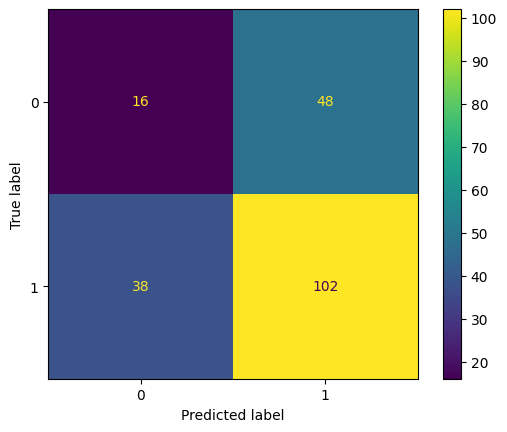

In [111]:
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report


y_true = test_score['true']
pred = test_score['pred']

cm = confusion_matrix(y_true, pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

disp.plot()

print(classification_report(y_pred=pred, y_true=y_true))